In [ ]:
### Tesina ###
### The economics behind two sided markets: key determinants of airbnb pricing in Mexico City ###
### Edgar Robles Díaz ###

In [2]:
import shapely  ##Convertir coordenadas a puntos ###
from shapely.geometry import Point
import cartopy ### Paquete para hacer mapas ###
from matplotlib import pyplot as plt ## Vizualizaciones ###
import pandas as pd ### manejo de datos ###
import seaborn as sns
import geoplot as gplt ### visualziación de datos espaciales ###
import geoplot.crs as gcrs
import geopandas as gpd
import mapclassify as mc
import contextily as ctx
import numpy as np


In [54]:
from matplotlib.colors import LinearSegmentedColormap

In [3]:
import pysal
import libpysal
import spreg

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [4]:
from pysal.lib import weights
from pysal.lib import cg as geometry

In [ ]:
### IMPORTAR DATOS DE STATA ###

In [5]:
df = pd.read_stata("listados_limpio_transportes_centros_puntos_apart_clean.dta")

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\pandas\io\stata.py:1433: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


In [6]:
df.set_index('id', inplace = True)

In [8]:
df.drop(['_ID', '_CX','_CY'], axis=1, inplace=True)

In [ ]:
### QUITAR OUTLIERS PARA FACILITAR LA VISUALIZACIÓN ###

In [9]:
df = df.drop(df.sort_values('precio').precio.tail(50).index, axis=0)

In [ ]:
### CREAR VARIABLE CON LA GEOMETRIA DE LAS COORDENADAS ###

In [10]:
df['geometry'] = list(zip(df.longitude, df.latitude))
df['geometry'] = df['geometry'].apply(Point)

In [16]:
geo_df = gpd.GeoDataFrame(df, geometry='geometry')

In [ ]:
### IMPORTAR SHAPEFILE DE LA CDMX ###

In [17]:
map_df = gpd.read_file('coloniascdmx.shp')

In [ ]:
### HAY POLIGONOS SIN VALORES, QUITARLOS PARA PODER HACER LAS VISUALIZACIONES ###

In [20]:
map_df = map_df.geometry.dropna()

In [22]:
extent = geo_df.longitude.min(), geo_df.latitude.min(), geo_df.longitude.max(), geo_df.latitude.max()

In [ ]:
### Insertar mapa de medios de transporte ###

In [23]:
trans = pd.read_csv('transporte.csv', encoding='latin1')

In [24]:
trans['geometry'] = list(zip(trans.longitud, trans.latitud))
trans['geometry'] = trans['geometry'].apply(Point)

In [25]:
geo_trans = gpd.GeoDataFrame(trans, geometry='geometry')

In [ ]:
### insertar bd de puntos de interés

In [26]:
puntos = pd.read_csv('puntos.csv', encoding = 'latin1')

In [27]:
puntos['geometry'] = list(zip(puntos.longitud, puntos.latitud))
puntos['geometry'] = puntos['geometry'].apply(Point)

geo_puntos = gpd.GeoDataFrame(puntos, geometry = 'geometry')

In [ ]:
### Agrupr valores para extrer puntos más mencionados (más cercanos) ###

In [29]:
pop_pun = pd.DataFrame(geo_df.groupby('nombre')['nombre'].count().sort_values(ascending=False)).rename({'nombre':'count'},axis=1)

In [ ]:
### agregar a bd de puntos de interés (con coordenadas y geometry) ###

In [30]:
geo_puntos = geo_puntos.merge(pop_pun, on='nombre')

In [31]:
extent

(-99.30059, 19.20911, -98.99580999999999, 19.53122)

In [ ]:
### ESTABLECER COLOR DE LOS PUNTOS PARA EL MAPA ###

In [33]:
plt.set_cmap('YlGnBu')

<Figure size 432x288 with 0 Axes>

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\geoplot\geoplot.py:625: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  extent = gpd.GeoSeries(self.extent) if self.extent is not None else None
C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\geoplot\geoplot.py:1743: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  url=getattr(ctx.sources, provider), ll=True
C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\geoplot\geoplot.py:1741: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  basemap, extent = ctx.bounds2img(


Text(0.5, 1.0, 'Distribución de precios de listados en la Ciudad de México')

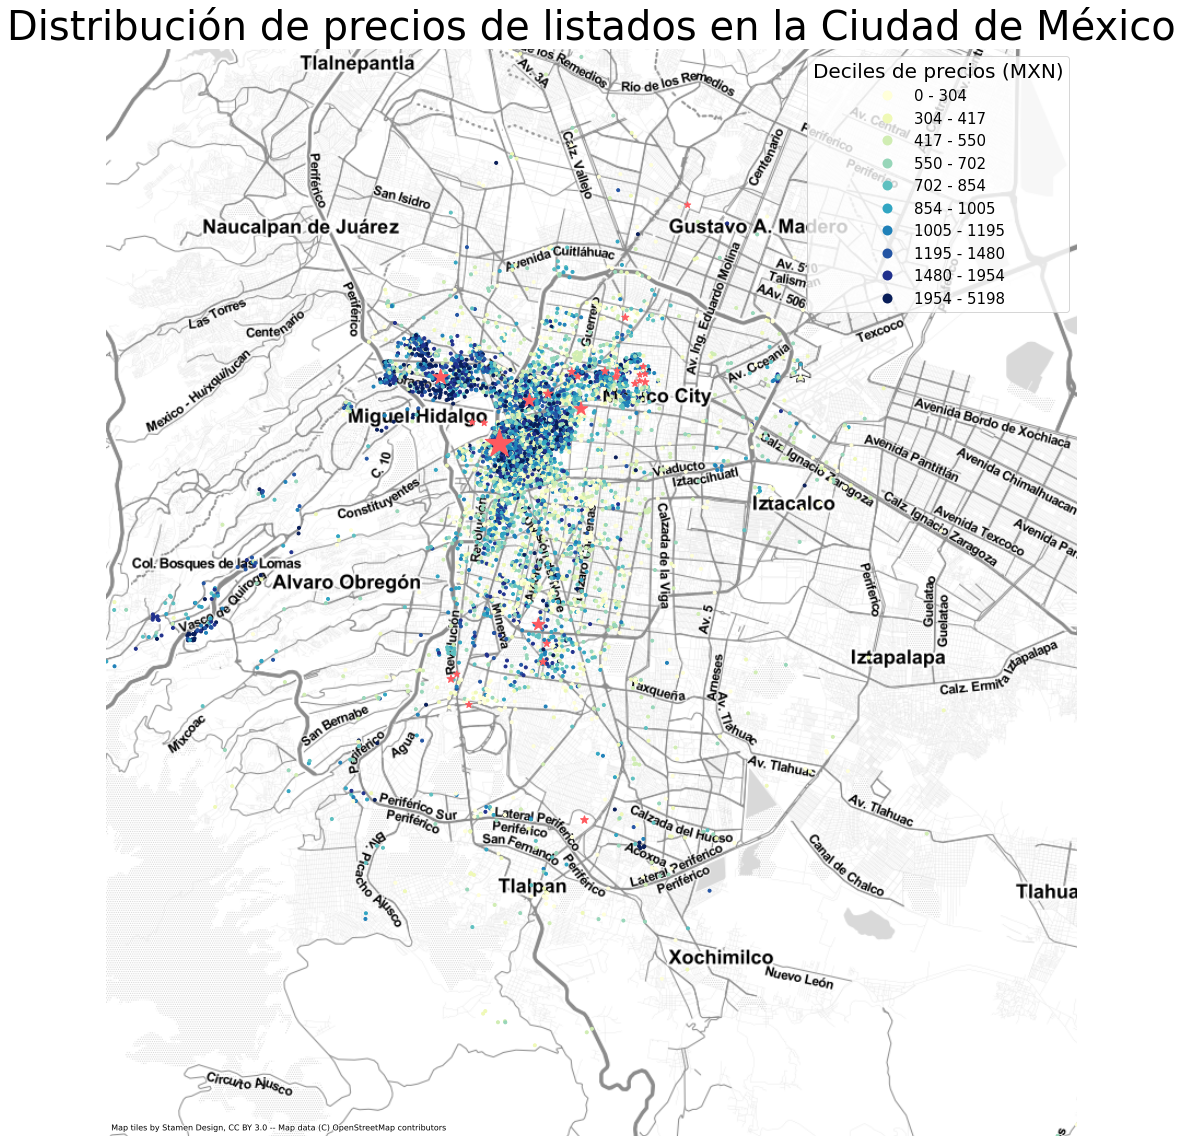

In [34]:
### Define el esquema de colores por deciles ###
scheme = mc.Quantiles(geo_df['precio'],
                      k=10)

### Cargar el mapa base, con la delimitación del shapefile original de la CDMX ###
ax = gplt.webmap(map_df, 
                 extent=extent, 
                 projection=gcrs.WebMercator(), 
                 figsize=(20,20))

### Agregar capa con caminos y nombres ###
ctx.add_basemap(ax,
                source=ctx.providers.Stamen.TonerLite)

### Mapea la distribución de precios (por color) ###
gplt.pointplot(geo_df, 
               hue='precio', 
               ax=ax, 
               scheme=scheme,
               s=3, 
               legend=True,
               extent=extent,  
               legend_kwargs={'frameon': True, 
                              'loc': 'upper right',
                              'fontsize':15, 
                              'title':'Deciles de precios (MXN)',
                              'title_fontsize':20})

### Mapea los puntos de interés de la CDMX ###
gplt.pointplot(geo_puntos,
               ax=ax,
               extent=extent,
               marker='*',
               color='#FF5A5F',
               scale='count',
               limits=(6,30))

### Agrega el título y cambia el tamaño de la letra ###
plt.title('Distribución de precios de listados en la Ciudad de México',
          fontsize=40)

In [46]:
met = pd.DataFrame(geo_df2.groupby('estacion_metro')['estacion_metro'].count().sort_values(ascending=False)).rename({'estacion_metro':'count'}, axis=1)

In [47]:
metrobus = pd.DataFrame(geo_df2.groupby('estacion_metrobus')['estacion_metrobus'].count().sort_values(ascending=False)).rename({'estacion_metrobus':'count'}, axis=1)

In [48]:
eco = pd.DataFrame(geo_df2.groupby('estacion_ecobici')['estacion_ecobici'].count().sort_values(ascending=False)).rename({'estacion_ecobici':'count'}, axis=1)

In [49]:
transtot = pd.concat([met, metrobus, eco])

In [50]:
transtot = transtot.reset_index().rename({'index':'nombre'},axis=1).set_index('nombre')

In [51]:
geo_trans = geo_trans.merge(transtot, on='nombre')

In [55]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['green', 'orange', 'red'])

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\geoplot\geoplot.py:256: UserWarning: Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".
  warnings.warn(


Text(0.5, 1.0, 'Ubicación medios de transporte (Metro-Metrobús-Ecobici) en la CDMX')

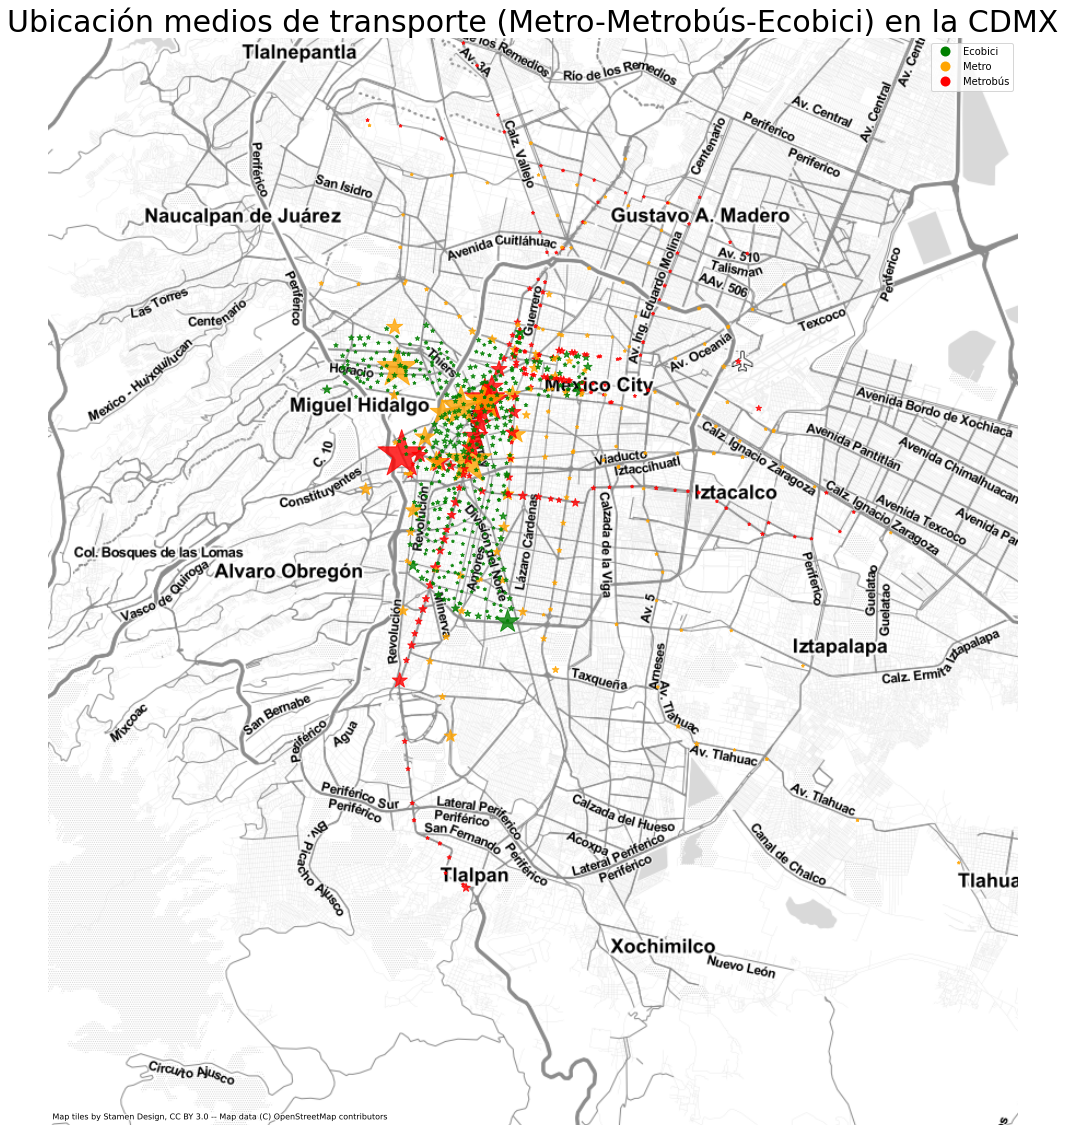

In [56]:
ax = gplt.webmap(map_df, extent=extent, projection=gcrs.WebMercator(), figsize=(20,20))
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
gplt.pointplot(geo_trans, marker='*',hue='medio', scale='count',ax=ax, cmap=cmap,legend=True, limits=(3,50), extent=extent, alpha = 0.8)
plt.title('Ubicación medios de transporte (Metro-Metrobús-Ecobici) en la CDMX', fontsize=30)

Text(0.5, 1.0, 'Densidad de Listados en la CDMX/Principales puntos de interés')

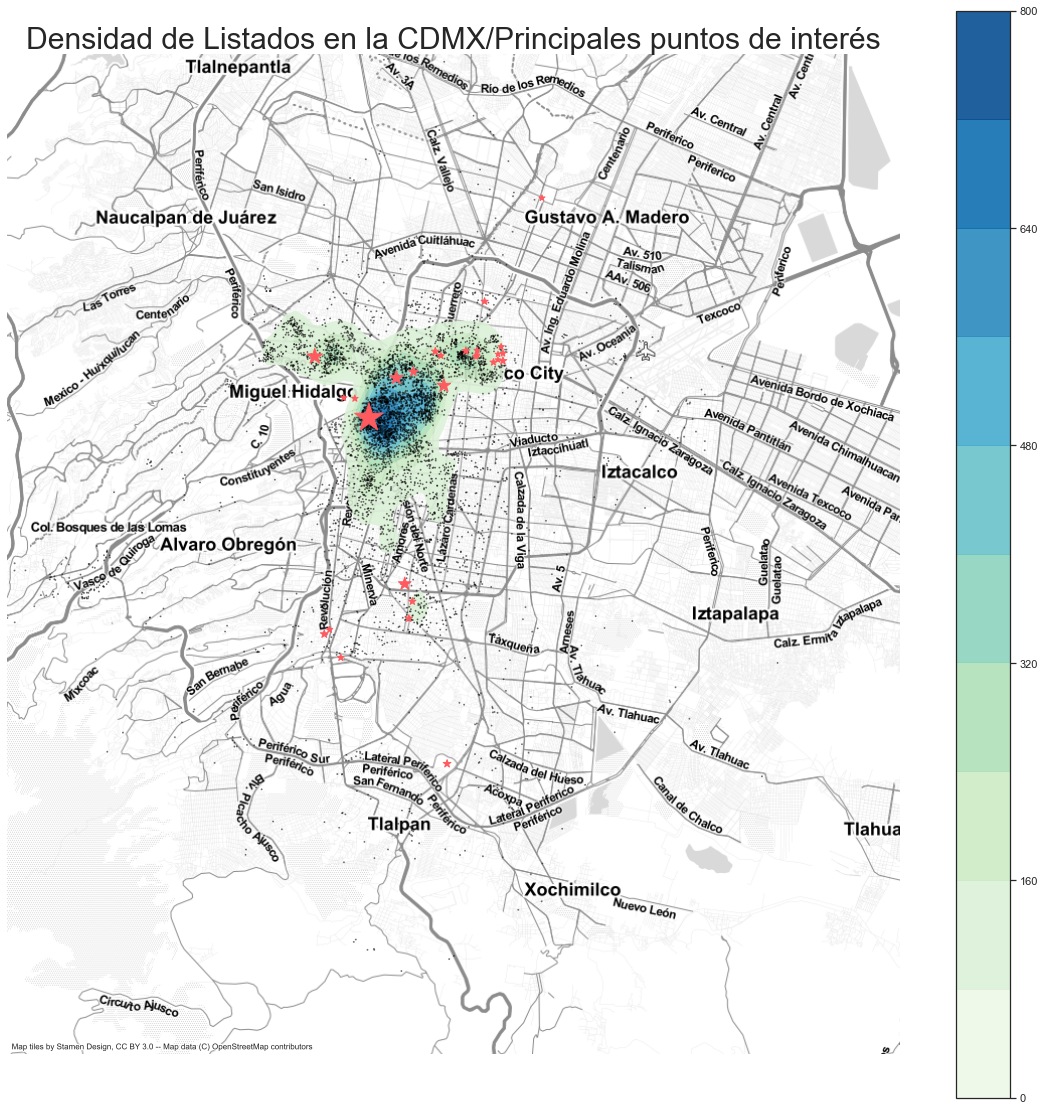

In [465]:
ax = gplt.webmap(map_df,
                 extent=extent, 
                 projection=gcrs.WebMercator(),
                 figsize=(20,20))

ctx.add_basemap(ax, 
                source=ctx.providers.Stamen.TonerLite)

gplt.kdeplot(geo_df2, 
             cmap='GnBu',
             shade=True,
             ax=ax,
             antialiased = True,
             alpha = 0.9, 
             cbar = True,
             bw='scott',
             legend_kwargs={'frameon': True, 
                            'loc': 'lower right',
                            'fontsize':20,
                            'title':'Densidad de listados'})

gplt.pointplot(geo_df2, s=1,
               color = 'black',
               ax=ax, alpha = 0.4)

gplt.pointplot(geo_puntos,
               ax=ax, 
               extent=extent,
               marker='*',
               color='#FF5A5F',
               scale='count', 
               limits=(6,30))

plt.title('Densidad de Listados en la CDMX/Principales puntos de interés',
         fontsize=30)

In [ ]:
### Datos con distribución completa de precios ###

In [57]:
df2 = pd.read_stata("listados_limpio_transportes_centros_puntos_apart_clean.dta")

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\pandas\io\stata.py:1433: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


In [58]:
df2.drop(['_ID', '_CX','_CY'], axis=1, inplace=True)

In [59]:
df2['geometry'] = list(zip(df2.longitude, df2.latitude))
df2['geometry'] = df2['geometry'].apply(Point)

In [232]:
geo_df2 = gpd.GeoDataFrame(df2, geometry='geometry')

In [233]:
geo_df2 = geo_df2.drop('has_gym', axis=1)

In [234]:
amen = pd.read_csv('amenities.csv')

In [235]:
amen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9656 entries, 0 to 9655
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               9656 non-null   int64
 1   elevator         9656 non-null   int64
 2   pool             9656 non-null   int64
 3   smoking_allowed  9656 non-null   int64
 4   hot_tub          9656 non-null   int64
 5   has_gym          9656 non-null   int64
dtypes: int64(6)
memory usage: 452.8 KB


In [236]:
amen.elevator = amen.elevator.astype('category')
amen.pool = amen.pool.astype('category')
amen.smoking_allowed = amen.smoking_allowed.astype('category')
amen.hot_tub = amen.hot_tub.astype('category')
amen.has_gym = amen.has_gym.astype('category')

In [237]:
geo_df2 = geo_df2.merge(amen, how='left', on='id')

In [66]:
### Matriz de distancia inversa sin threshold de prueba  ###

In [ ]:
w_hy = weights.distance.DistanceBand.from_dataframe(geo_df2, 1.5, binary=False)

In [ ]:
### Matriz de vecinos más cercanos de prueba (k = 10) ###

In [77]:
w_knn = libpysal.weights.KNN.from_dataframe(geo_df2, k = 45)

In [78]:
w_knn.transform = 'V'

In [ ]:
### Estimación de Índice de Moran Local ###

In [149]:
local_moran = pysal.explore.esda.moran.Moran_Local(geo_df2.ln_price, w_knn, permutations=999)

In [150]:
local_moran.Is

array([ 0.12331033,  0.40392312, -0.03717378, ...,  0.45443024,
        0.07402977,  0.22649408])

In [ ]:
### Estimación de Índice de Moran Global ###

In [145]:
moran = pysal.explore.esda.moran.Moran(geo_df2.ln_price, w_knn)

In [146]:
moran.I, moran.p_sim

(0.273130599201274, 0.001)

In [ ]:
### Estimación de variable de ponderación espacial ###

In [147]:
lag_lnprice = pysal.lib.weights.lag_spatial(w_knn, geo_df2.ln_price)
ln_price = geo_df2.ln_price

In [ ]:
### Filtrar las variables de acuerdo al nivel de significancia de la prueba de Moran Local ###

In [151]:
sigs = ln_price[local_moran.p_sim <= 0.05]
W_sigs = lag_lnprice[local_moran.p_sim <= 0.05]

insigs = ln_price[local_moran.p_sim > 0.05]
W_insigs = lag_lnprice[local_moran.p_sim > 0.05]

In [152]:
b,a = np.polyfit(ln_price, lag_lnprice, 1)

In [ ]:
### Crear matriz W con la paquetería libpysal para calcular el modelo SAR ###

In [ ]:
w = libpysal.weights.KNN.from_dataframe(geo_df2, k=10)

In [ ]:
#### Permutación de valores de I de Moran y comparar con versión global ###

NameError: name 'moran' is not defined

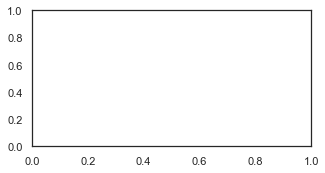

In [463]:
f, ax = plt.subplots(1,1,figsize=(5,2.5))

counts,  breaks, patches = ax.hist(moran.sim, bins=100, color='k', density=True)

ax.vlines(moran.I, 0,200, color='red', linestyle='--')

for break_,patch in zip(breaks,patches):
    if break_ > moran.I:
        patch.set_facecolor('r')
        
sns.despine(ax=ax, left=True)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_title("Distribución de referencia $I$ de Moran", fontsize=16)


plt.text(s='$permutations = %.3f$' % moran.permutations,
         x=0.3,
         y=0.01,
         fontsize=8)

plt.text(s='$pseudo pvalue= %.3f$' % moran.p_sim,
         x=0.3,
         y=20, 
         fontsize=8)

plt.text(s='$z stat= %.3f$' % moran.z_norm,
         x=0.3,
         y=40, 
         fontsize=8)

plt.text(s='$std dev= %.3f$' % moran.seI_rand,
         x=0.3,
         y=60, 
         fontsize=8)

plt.text(s='$mean= %.3f$' % moran.EI_sim,
         x=0.3,
         y=80, 
         fontsize=8)

plt.text(s='$E[I] = %.5f$' % moran.EI,
         x=0.3,
         y=100, 
         fontsize=8)

plt.text(s='$Índice Moran= %.3f$' % moran.I,
         x=0.3,
         y=120, 
         fontsize=8)

plt.show()

In [ ]:
### Filtro para seleccionar los ínidices significativos al 5% y asignar su respectivo cuadrante ###

In [188]:
quadfilter = (local_moran.p_sim <= 0.05)*(local_moran.q)

In [42]:
quadfilter2 = (local_moran.p_sim <= 0.01)*(local_moran.q)

In [189]:
sigfilter = local_moran.Is.copy()
sigfilter[local_moran.p_sim > 0.005] = 0

In [ ]:
#### Plot de I de Moran con la señalización de los valores significativos ###

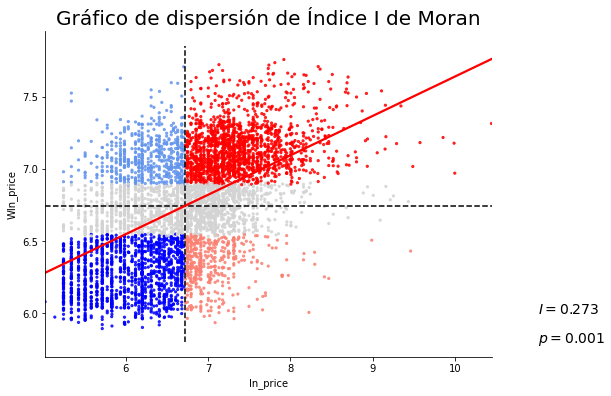

In [193]:
quadrantcolor = np.array((['lightgrey', 'red', 'cornflowerblue', 'blue', 'salmon']))[quadfilter]

plt.figure(figsize=(8,6))

sns.regplot(ln_price, 
            lag_lnprice,
            line_kws = dict(color='r'),
            scatter_kws = dict(c=quadrantcolor,
                                  marker = '.',
                                  s = 5,
                                  color = None),
            ci=None)

plt.vlines(ln_price.mean(), 
           *plt.gca().get_ylim(),
           color='k',
           linestyle = '--')
           
plt.hlines(lag_lnprice.mean(),
          *plt.gca().get_xlim(),
          color='k',
          linestyle='--')

plt.text(s='$I = %.3f$' % moran.I,
         x=11,
         y=6,
         fontsize=14)

plt.text(s='$p= %.3f$' % moran.p_sim,
         x=11,
         y=5.8, 
         fontsize=14)

plt.ylabel('Wln_price')

plt.title('Gráfico de dispersión de Índice I de Moran', fontsize=20)

sns.despine()

plt.savefig('Moran.png')

In [196]:
quadcolor = quadrantcolor

In [197]:
quadict = {'lightgrey':'No significativo',
           'red':'High-High',
           'blue':'Low-Low',
           'salmon':'High-Low',
           'cornflowerblue':'Low-High'}

In [198]:
quadcolor = [quadict[color] for color in quadcolor]

In [ ]:
### LISA cluster (shapefile) ###

In [ ]:
### Función para crear colores discretos ### 

In [50]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [200]:
cmap = LinearSegmentedColormap.from_list('mycmap', ['red', 'blue', 'lightgrey'])

In [ ]:
plt.set_cmap('Set2')

In [ ]:
### LISA Cluster (Webmap) ###

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\geoplot\geoplot.py:625: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  extent = gpd.GeoSeries(self.extent) if self.extent is not None else None
C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\geoplot\geoplot.py:1743: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  url=getattr(ctx.sources, provider), ll=True
C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\geoplot\geoplot.py:1741: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  basemap, extent = ctx.bounds2img(
C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\geoplot\geoplot.py:1793: FutureWarning:     You are passing non-geometry data to the GeoSeries construct

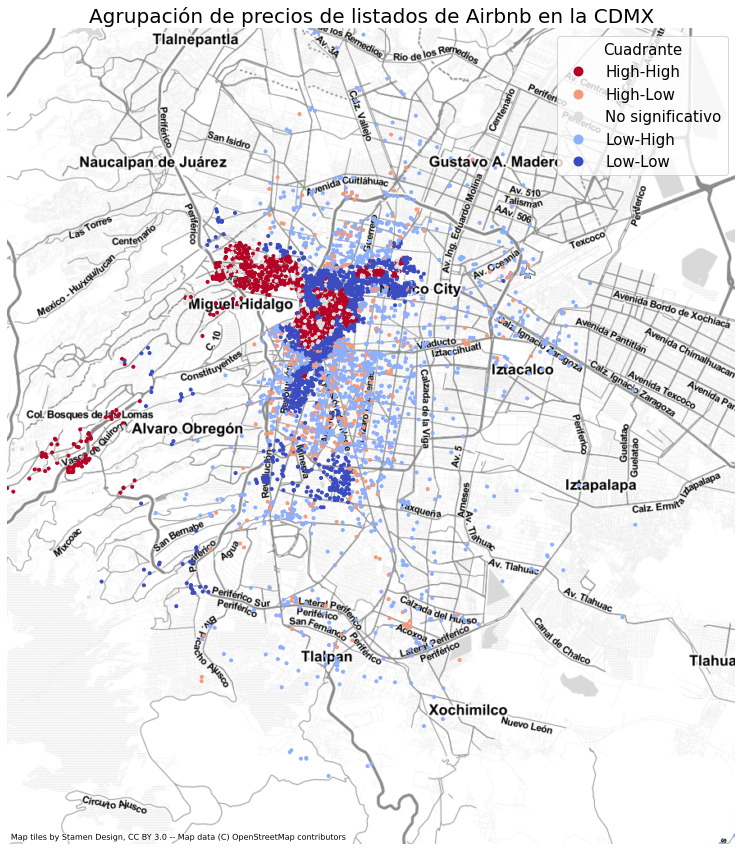

In [218]:
ax = gplt.webmap(map_df,
                 extent=extent,
                 projection=gcrs.WebMercator(),
                 figsize=(15,15))

ctx.add_basemap(ax, 
                source=ctx.providers.Stamen.TonerLite)

gplt.pointplot(geo_df2,
               hue=quadcolor,
               ax=ax,
               s=3, 
               cmap='coolwarm_r',
               legend=True,
               legend_labels=['High-High','High-Low','No significativo', 'Low-High', 'Low-Low'],
               extent=extent,
               legend_kwargs={'title':'Cuadrante',
                              'title_fontsize':15,
                              'fontsize':15})

plt.title('Agrupación de precios de listados de Airbnb en la CDMX', fontsize=20)
plt.savefig('LISA.png')

In [106]:
w_knn.transform = 'R'

In [238]:
dummies = ['host_is_superhost','host_identity_verified', 'host_has_profile_pic',
             'insta_book', 'require_guest_phone_verification', 'require_guest_profile_picture',
           'has_wifi', 'allows_pets', 'has_gym', 'has_breakfast',
           'has_kitchen', 'has_washer', 'has_dryer',
            'has_parking', 'room_type'
          ]

In [239]:
for dum in dummies:
    geo_df2[dum] = geo_df2[dum].cat.rename_categories({'False':0, 'True':1})

In [289]:
geo_df2['tipo_propiedad'] = geo_df2.tipo_propiedad.cat.rename_categories({'Privado':0, 'Comercial':1})

In [ ]:
### Categorización de variables de dummy de bool (T,F) a categórica (0,1) ###

In [68]:
geo_df2 = pd.concat((geo_df2, pd.get_dummies(geo_df2['room_type'], drop_first=True), pd.get_dummies(geo_df2['cancelacion'], drop_first=True)), axis = 1).drop(['cancelacion', 'room_type'], axis = 1)

In [240]:
geo_df2.rename({'require_guest_phone_verification':'req_guest_phone_ver'}, axis = 1, inplace=True)

In [241]:
geo_df2.rename({'host_identity_verified':'host_id_ver'}, axis = 1, inplace=True)

In [422]:
x_clean = geo_df2[[  
    
                 ### Tamaño y características físicas  ###
                    'bedrooms', 'bathrooms', 'accommodates', 'beds',
                 ### Características listado ###
                    'insta_book',
                 ### Ubicación  #### 
                    'distancia_centro', 'pi_dist',
                 ### Amenidades #### 
                    'has_parking', 'has_breakfast', 'has_wifi', 'has_gym', 'pool', 'hot_tub', 'elevator',
                 ### Reglas ### 
                    'minimum_nights', 'allows_pets', 'smoking_allowed' , 'req_guest_phone_ver',
                  
                 ### Características anfitrión ### 
                    'host_is_superhost', 'tipo_propiedad','host_has_profile_pic', 'host_id_ver',
                  
                  ### Reputación ###
                  'review_scores_rating', 'number_of_reviews']]

In [243]:
x_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5866 entries, 0 to 5865
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   bedrooms              5866 non-null   float64 
 1   bathrooms             5866 non-null   float64 
 2   accommodates          5866 non-null   int32   
 3   beds                  5866 non-null   float64 
 4   insta_book            5866 non-null   category
 5   distancia_centro      5866 non-null   float64 
 6   pi_dist               5866 non-null   float64 
 7   metro_distance        5866 non-null   float64 
 8   metrobus_distance     5866 non-null   float64 
 9   ecobici_distance      5866 non-null   float64 
 10  has_parking           5866 non-null   category
 11  has_breakfast         5866 non-null   category
 12  has_wifi              5866 non-null   category
 13  has_gym               5866 non-null   category
 14  pool                  5866 non-null   category
 15  hot_

In [ ]:
### Selección  de variables explicativas ###

In [ ]:
### Regresión de prueba ###

In [456]:
m_test_ols = spreg.OLS(geo_df2['ln_price'].values[:,None], x_clean.values,robust='white' ,moran=True, w = w45, spat_diag = True ,name_x = x_clean.columns.tolist(), name_y='(log)price')

In [457]:
print(m_test_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  (log)price                Number of Observations:        5767
Mean dependent var  :      6.6854                Number of Variables   :          25
S.D. dependent var  :      0.6803                Degrees of Freedom    :        5742
R-squared           :      0.4699
Adjusted R-squared  :      0.4677
Sum squared residual:    1414.715                F-statistic           :    212.0811
Sigma-square        :       0.246                Prob(F-statistic)     :           0
S.E. of regression  :       0.496                Log likelihood        :   -4131.056
Sigma-square ML     :       0.245                Akaike info criterion :    8312.111
S.E of regression ML:      0.4953                Schwarz criterion     :    8478.609

White Standard Errors
-------------------------------------------------------

In [ ]:
m_test = spreg.GM_Lag(geo_df2['ln_price'].values[:,None], x2.values, w = w30, spat_diag=True, name_x=x2.columns.tolist(), name_y='ln(price)')

In [ ]:
m_2_1 = spreg.ML_Lag(geo_df2['ln_price'].values[:,None], x.values, w = w, method='ord',spat_diag=True, name_x=x.columns.tolist(), name_y='ln(price)')

In [ ]:
m_test.pr2

In [ ]:
print(m_test.summary)

In [ ]:
m1 = spreg.OLS(geo_df2['ln_price'].values[:, None], x.values, w = w, spat_diag = True)

In [ ]:
m2 = spreg.GM_Lag(geo_df2['ln_price'].values[:,None], x.values, w = w, spat_diag=True, name_x=x.columns.tolist(), name_y='ln(price)' )

In [ ]:
### Generar matrices de pesos con diferentes números de vecinos más cercanos ###

In [81]:
k = [10, 15,20,25,30,35,40,45,50,55,60,65,70,75,80]

In [292]:
mats= [libpysal.weights.KNN.from_dataframe(geo_df2, 
                                           k=i)
      for i in k ]

In [293]:
for w in mats:
    w.transform = 'V'

In [84]:
### Generar diferentes modelos SAR con ML para extraer r cuadrada y AIC ###

In [85]:
knn_models_gm = [spreg.GM_Lag(geo_df2['ln_price'].values[:,None],
              x_clean.values,
              w = w, 
              robust='white',
              spat_diag=True, 
              name_x=x_clean.columns.tolist(),
              name_y='ln(price)')
for w in mats]

In [86]:
### Guardar resultados en una lista para iterar GLM ###

In [87]:
r_sq = [m.pr2 for m in knn_models_gm]

In [88]:
rho = [m.rho for m in knn_models_gm]

In [ ]:
### GS2SLS no tiene AIC porque no utiliza el métdodo de Máxima Verosimilitud ###

In [ ]:
### Estimar modelos con ML_Lag en vez de GLM_Lag ###

In [92]:
knn_models_ml =[ spreg.ML_Lag(geo_df2['ln_price'].values[:,None],
                 x_clean.values,
                 w = w,
                 method='ord',
                 spat_diag=True,
                 name_x=x_clean.columns.tolist(),
                 name_y='ln(price)')
for w in mats
               ]

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\scipy\optimize\_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [93]:
ml_r_sq = [ml.pr2 for ml in knn_models_ml]

In [94]:
ml_aic = [ml.aic for ml in knn_models_ml]

In [95]:
sns.set_style('whitegrid')

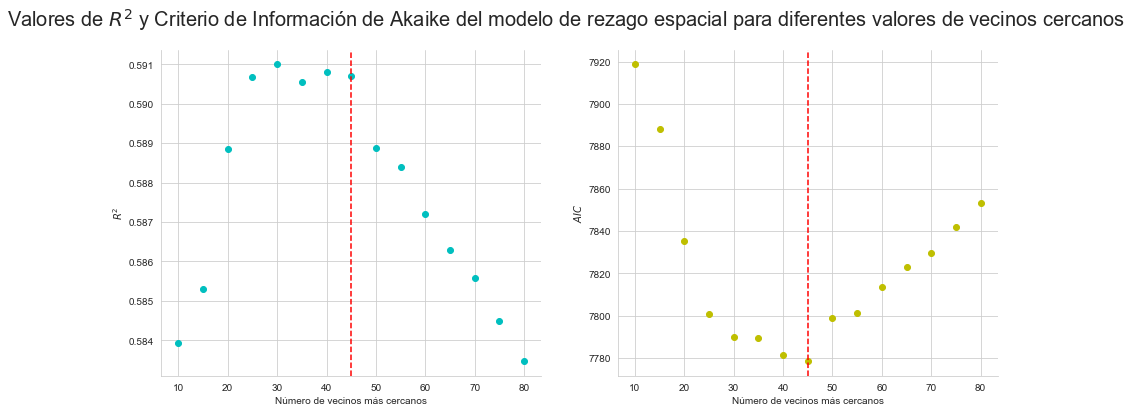

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Valores de $R^2$ y Criterio de Información de Akaike del modelo de rezago espacial para diferentes valores de vecinos cercanos', fontsize=20)
fig.set_figheight(6)
fig.set_figwidth(15)
ax1.scatter(k, r_sq,c = 'c')
ax1.axvline(x=45,c='r', linestyle='--')
ax2.axvline(x=45,c='r', linestyle='--')
ax1.yaxis.set_label_text('$R^2$')
ax2.yaxis.set_label_text('$AIC$')
ax1.xaxis.set_label_text('Número de vecinos más cercanos')
ax2.xaxis.set_label_text('Número de vecinos más cercanos')
ax2.scatter(k, ml_aic, c='y')
sns.despine()
plt.savefig('RAIC.png')

In [ ]:
from statsmodels.compat import lzip

In [ ]:
import statsmodels.stats.api as sms

In [98]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [99]:
from statsmodels.tools.tools import add_constant

In [360]:
x = add_constant(x_clean)

In [361]:
pd.Series([variance_inflation_factor(x.values, i) 
               for i in range(x.shape[1])], 
              index=x.columns)

const                   2259.136576
bedrooms                   2.402108
bathrooms                  1.844509
accommodates               3.723209
beds                       3.272280
insta_book                 1.038027
distancia_centro           1.742769
pi_dist                    1.690215
has_parking                1.332623
has_breakfast              1.014854
has_wifi                   1.021969
has_gym                    1.785891
pool                       1.935274
hot_tub                    1.373032
elevator                   1.383710
minimum_nights             1.023528
allows_pets                1.072655
smoking_allowed            1.079223
req_guest_phone_ver        1.033864
host_is_superhost          1.175077
tipo_propiedad             1.059736
host_has_profile_pic       1.009987
host_id_ver                1.114065
review_scores_rating       1.109715
number_of_reviews          1.186240
dtype: float64

In [115]:
pd.set_option('display.max_columns', 50)

In [116]:
geo_df2.describe()

level_0        index            id  host_response_rate  \
count  5866.000000  5866.000000  5.866000e+03         5866.000000   
mean   2935.173372  3894.248551  2.401853e+07           97.206614   
std    1695.047946  2262.198399  8.869074e+06            9.882253   
min       0.000000     2.000000  5.895500e+04            0.000000   
25%    1466.250000  1923.250000  1.832947e+07          100.000000   
50%    2936.500000  3881.000000  2.514386e+07          100.000000   
75%    4402.750000  5868.750000  3.171977e+07          100.000000   
max    5869.000000  7821.000000  3.666805e+07          100.000000   

       host_total_listings_count     latitude    longitude  accommodates  \
count                5866.000000  5866.000000  5866.000000   5866.000000   
mean                    6.039720    19.408727   -99.167360      3.414763   
std                    11.048569     0.033660     0.027254      1.996582   
min                     0.000000    19.209110   -99.300590      1.000000   
25%                     1.000000    19.397063   -99.177908      2.000000   
50%                     2.000000    19.415835   -99.167895      3.000000   
75%                     5.000000    19.431110   -99.155433      4.000000   
max                   125.000000    19.531220   -98.995810     41.000000   

         bathrooms     bedrooms         beds        precio  security_deposit  \
count  5866.000000  5866.000000  5866.000000   5866.000000       5866.000000   
mean      1.360126     1.488408     1.853222   1096.062223       2195.472213   
std       0.617586     0.837293     1.168106   1157.685561       6085.214310   
min       0.000000     0.000000     0.000000    152.000000          0.000000   
25%       1.000000     1.000000     1.000000    493.000000          0.000000   
50%       1.000000     1.000000     2.000000    854.000000          0.000000   
75%       2.000000     2.000000     2.000000   1328.000000       2846.000000   
max      11.000000    24.000000    12.000000  34147.000000      95653.000000   

       cleaning_fee  guests_included  extra_people  minimum_nights  \
count   5866.000000      5866.000000   5866.000000     5866.000000   
mean     275.753665         1.906239    136.519605        2.050119   
std      286.192545         1.450192    202.613042        2.700802   
min        0.000000         1.000000      0.000000        1.000000   
25%        0.000000         1.000000      0.000000        1.000000   
50%      280.000000         1.000000    100.000000        2.000000   
75%      403.500000         2.000000    200.000000        2.000000   
max     6829.000000        16.000000   3794.000000       90.000000   

       number_of_reviews  number_of_reviews_ltm  review_scores_rating  \
count        5866.000000            5866.000000           5866.000000   
mean           35.676952              19.216843             95.771224   
std            44.644590              19.779432              6.419400   
min             1.000000               1.000000             20.000000   
25%             6.000000               5.000000             94.000000   
50%            19.000000              12.000000             97.000000   
75%            48.000000              27.000000            100.000000   
max           362.000000             133.000000            100.000000   

       review_scores_accuracy  review_scores_cleanliness  \
count             5866.000000                5866.000000   
mean                 9.798841                   9.667576   
std                  0.626583                   0.717076   
min                  2.000000                   2.000000   
25%                 10.000000                   9.000000   
50%                 10.000000                  10.000000   
75%                 10.000000                  10.000000   
max                 10.000000                  10.000000   

       review_scores_checkin  review_scores_communication  \
count            5866.000000                  5866.000000   
mean                9.872656   

In [ ]:
w_i_dist = libpysal.weights.DistanceBand.from_dataframe(geo_df2, 1.5, binary=False)

In [ ]:
w_isqu_dist = libpysal.weights.DistanceBand.from_dataframe(geo_df2, 1.5, binary=False, alpha = -2)

In [ ]:
w_cut = libpysal.weights.DistanceBand.from_dataframe(geo_df2, 1.5, binary = True, p = 2)

In [ ]:
w_k30 = libpysal.weights.KNN.from_dataframe(geo_df2, k=30)

In [ ]:
w_k30.transform

In [ ]:
x_clean

In [443]:
w45 = libpysal.weights.KNN.from_dataframe(geo_df2, k=45)

In [444]:
w45.transform = 'V'

# SAR (GM) ###

In [425]:
GM_mk45 = spreg.GM_Lag(geo_df2['ln_price'].values[:,None], x_clean.values, w = w45, robust='white' ,spat_diag=True, name_x=x_clean.columns.tolist(), name_y='ln(price)', name_w='KNN weight matrix (k=45)')

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\spreg\user_output.py:438: UserWarning: w must be API-compatible pysal weights object
  warn("w must be API-compatible pysal weights object")


In [426]:
print(GM_mk45.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :KNN weight matrix (k=45)
Dependent Variable  :   ln(price)                Number of Observations:        5767
Mean dependent var  :      6.6854                Number of Variables   :          26
S.D. dependent var  :      0.6803                Degrees of Freedom    :        5741
Pseudo R-squared    :      0.5886
Spatial Pseudo R-squared:  0.4911

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.3238593       0.5475223       0.5914997       0.5541857
            bedrooms       0.0653830       0.0237652       2.7512021       0.0059377
           bathrooms     

# SEM (GM)

In [435]:
GM_err_mk45 = spreg.GM_Error_Het(geo_df2['ln_price'].values[:,None], x_clean.values ,w = w45,name_x=x_clean.columns.tolist(), name_y='ln(price)', name_w='KNN weight matrix (k=45)')

C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\spreg\user_output.py:438: UserWarning: w must be API-compatible pysal weights object
  warn("w must be API-compatible pysal weights object")


In [436]:
print(GM_err_mk45.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :KNN weight matrix (k=45)
Dependent Variable  :   ln(price)                Number of Observations:        5767
Mean dependent var  :      6.6854                Number of Variables   :          25
S.D. dependent var  :      0.6803                Degrees of Freedom    :        5742
Pseudo R-squared    :      0.4607
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       5.0813775       0.5407484       9.3969354       0.0000000
            bedrooms       0.0631209       0.0229734       2.747562

# SAR (ML)

In [448]:
ML_mk45 = spreg.ML_Lag(geo_df2['ln_price'].values[:,None], x_clean.values, w = w45,  method='ord',spat_diag=True, name_x=x_clean.columns.tolist(), name_y='ln(price)')


C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\scipy\optimize\_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
C:\Users\edari\anaconda3\envs\Tesis\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [449]:
print(ML_mk45.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = ORD)
----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   ln(price)                Number of Observations:        5767
Mean dependent var  :      6.6854                Number of Variables   :          26
S.D. dependent var  :      0.6803                Degrees of Freedom    :        5741
Pseudo R-squared    :      0.5885
Spatial Pseudo R-squared:  0.4928
Sigma-square ML     :       0.190                Log likelihood        :   -3441.250
S.E of regression   :       0.436                Akaike info criterion :    6934.501
                                                 Schwarz criterion     :    7107.659

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------

# SEM (ML)

In [450]:
ML_err_mk45 = spreg.ML_Error(y=geo_df2['ln_price'].values[:,None], x=x_clean.values, w = w45,  method='ord',spat_diag=True, name_x=x_clean.columns.tolist(), name_y='ln(price)')

In [451]:
print(ML_err_mk45.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = ORD)
------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   ln(price)                Number of Observations:        5767
Mean dependent var  :      6.6854                Number of Variables   :          25
S.D. dependent var  :      0.6803                Degrees of Freedom    :        5742
Pseudo R-squared    :      0.4599
Sigma-square ML     :       0.186                Log likelihood        :   -3410.693
S.E of regression   :       0.432                Akaike info criterion :    6871.385
                                                 Schwarz criterion     :    7037.883

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------------

In [118]:
import scipy.stats as stats

Skewness: -0.050618
Kurtosis: -0.546107


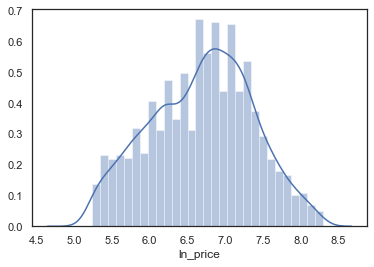

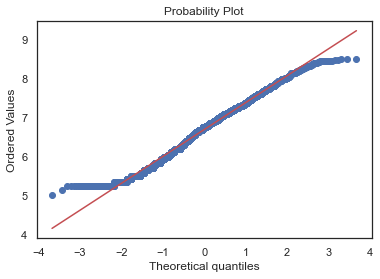

In [321]:
sns.distplot(geo_df2['ln_price'], kde=True,);
fig = plt.figure()
res = stats.probplot(geo_df3['ln_price'], plot=plt)
print("Skewness: %f" % geo_df3['ln_price'].skew())
print("Kurtosis: %f" % geo_df3['ln_price'].kurt())

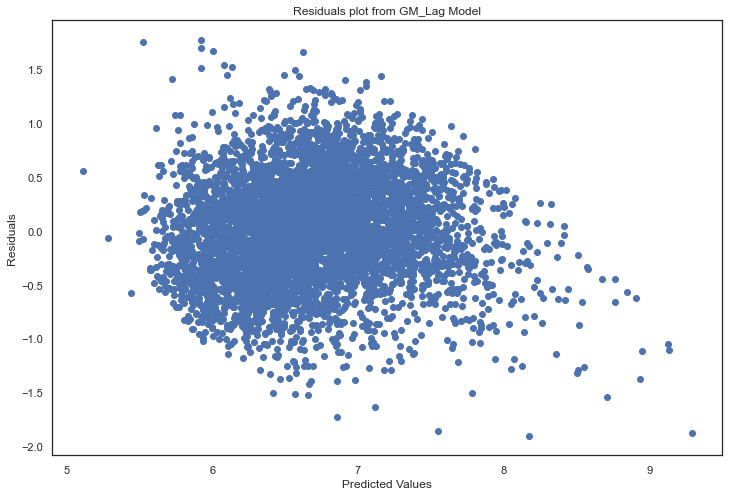

In [452]:
plt.figure(figsize=(12,8))
plt.scatter(ML_mk45.predy, ML_mk45.e_pred); # print resids vs predictions
plt.title("Residuals plot from GM_Lag Model")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.savefig('LR_Residual_Plot')

In [409]:
u = GM_mk45.u

In [410]:
u.min()

-5.855250059741946

In [408]:
ex = pd.DataFrame(GM_mk45.x, columns= x.columns)

In [420]:
out = geo_df2.iloc[out].index

In [415]:
ex.iloc[4266]

const                     1.000000
bedrooms                 11.000000
bathrooms                11.000000
accommodates             41.000000
beds                     11.000000
insta_book                0.000000
distancia_centro          5.423982
pi_dist                   0.372657
has_parking               0.000000
has_breakfast             1.000000
has_wifi                  1.000000
has_gym                   0.000000
pool                      0.000000
hot_tub                   0.000000
elevator                  0.000000
minimum_nights            3.000000
allows_pets               1.000000
smoking_allowed           0.000000
req_guest_phone_ver       0.000000
host_is_superhost         0.000000
tipo_propiedad            1.000000
host_has_profile_pic      1.000000
host_id_ver               0.000000
review_scores_rating    100.000000
number_of_reviews         2.000000
residual                 -5.855250
Name: 4266, dtype: float64

In [421]:
geo_df2.drop(out, inplace=True)

In [411]:
ex['residual'] = u

In [417]:
out = ex[ex['residual'] == ex['residual'].min()].index

# Efectos directos, indirectos y totales

In [408]:
b=m_k45.betas[:-1]
rho=m_k45.betas[-1]
btot=b/(float(1)-rho)
bind=btot-b

full_eff=pd.DataFrame(np.hstack([b,bind,btot]),index=['Constant']+x_clean.columns.tolist(), columns=['Direct','Indirect','Total'])
full_eff

Direct  Indirect     Total
Constant              0.469787  0.757409  1.227196
Entire home/apt       1.021715  1.647247  2.668961
Private room          0.349516  0.563504  0.913020
bedrooms              0.063605  0.102546  0.166150
bathrooms             0.162888  0.262615  0.425503
accommodates          0.047576  0.076705  0.124281
beds                  0.016944  0.027318  0.044262
insta_book           -0.037108 -0.059827 -0.096935
distancia_centro      0.007625  0.012293  0.019919
pi_dist              -0.015705 -0.025321 -0.041026
metro_distance        0.013270  0.021395  0.034665
metrobus_distance    -0.015470 -0.024942 -0.040412
ecobici_distance     -0.017486 -0.028192 -0.045678
has_parking           0.107283  0.172966  0.280249
has_breakfast         0.084844  0.136789  0.221633
has_wifi             -0.008479 -0.013670 -0.022149
has_gym               0.000646  0.001042  0.001688
pool                  0.027708  0.044672  0.072381
hot_tub               0.083927  0.135311  0.219238
elevator              0.069829  0.112581  0.182410
moderado              0.000057  0.000091  0.000148
estricto_14           0.021528  0.034709  0.056237
minimum_nights       -0.009553 -0.015401 -0.024954
allows_pets          -0.013401 -0.021605 -0.035006
smoking_allowed      -0.041066 -0.066207 -0.107273
req_guest_phone_ver   0.145878  0.235190  0.381068
host_is_superhost     0.052205  0.084167  0.136372
tipo_propiedad        0.069257  0.111659  0.180917
host_has_profile_pic  0.460263  0.742053  1.202315
host_id_ver          -0.017621 -0.028409 -0.046029
review_scores_rating  0.002436  0.003927  0.006363
number_of_reviews    -0.000495 -0.000799 -0.001294

In [134]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

In [145]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(ML_mk45.u, ML_mk45.x)
lzip(name, test)

[('Lagrange multiplier statistic', 443.00579539922154),
 ('p-value', 8.16068812149561e-77),
 ('f-value', 17.66324910642133),
 ('f p-value', 3.527940654848128e-80)]

In [462]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(m_test_ols.u)
lzip(name, test)

[('Jarque-Bera', array([0.78968215])),
 ('Chi^2 two-tail prob.', array([0.67378711])),
 ('Skew', array([-0.02852334])),
 ('Kurtosis', array([2.99434091]))]

In [274]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(geo_df3.ln_price)
lzip(name, test)

[('Jarque-Bera', 74.82544056640704),
 ('Chi^2 two-tail prob.', 5.647575272274855e-17),
 ('Skew', -0.05060094594955444),
 ('Kurtosis', 2.4533302855819725)]

In [151]:
geo_df2.corr()['ln_price']

level_0                       -0.091604
index                         -0.091660
id                            -0.092704
host_response_rate             0.081817
host_total_listings_count      0.246333
latitude                       0.179440
longitude                     -0.256057
accommodates                   0.569297
bathrooms                      0.504647
bedrooms                       0.478034
beds                           0.477325
precio                         0.768238
security_deposit               0.129223
cleaning_fee                   0.483680
guests_included                0.334853
extra_people                   0.224503
minimum_nights                -0.021452
number_of_reviews              0.107634
number_of_reviews_ltm          0.088032
review_scores_rating           0.038247
review_scores_accuracy         0.049801
review_scores_cleanliness      0.120838
review_scores_checkin          0.018657
review_scores_communication    0.011519
review_scores_location         0.085782


array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'accommodates'}>],
       [<AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'distancia_centro'}>,
        <AxesSubplot:title={'center':'pi_dist'}>],
       [<AxesSubplot:title={'center':'minimum_nights'}>,
        <AxesSubplot:title={'center':'review_scores_rating'}>,
        <AxesSubplot:title={'center':'number_of_reviews'}>]], dtype=object)

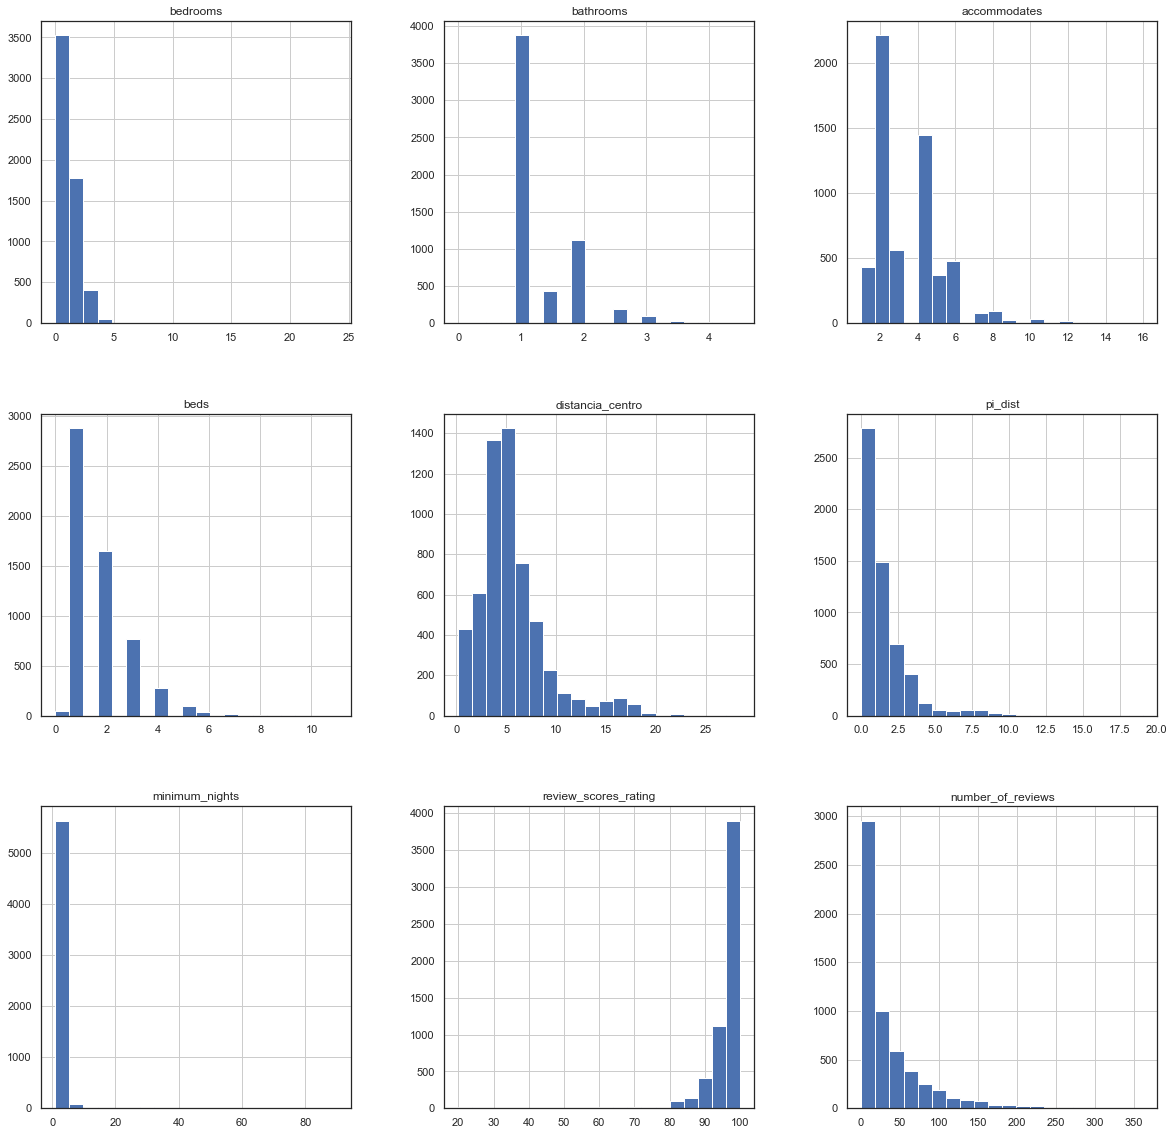

In [434]:
geo_df2[x_clean.columns].hist(figsize=(20,20), bins=20)

In [313]:
ind_price_out = geo_df3[geo_df3['precio'] >= 4000].index


In [317]:
ind_price_out

Int64Index([   3,  290,  392,  465,  677,  678,  741,  761,  765,  766,  774,
             943, 1142, 1483, 1620, 1663, 1680, 1748, 1842, 1886, 1887, 1892,
            1905, 1915, 1930, 1933, 1977, 3695, 3757, 3954, 3973, 3995, 4134,
            4166, 4232, 4790, 5563, 5575, 5601, 5664, 5675],
           dtype='int64')

In [316]:
geo_df2[geo_df2['precio'] >= 4000].index

Int64Index([   3,  290,  392,  465,  677,  678,  741,  761,  765,  766,  774,
             943, 1142, 1483, 1620, 1663, 1680, 1748, 1842, 1886, 1887, 1892,
            1905, 1915, 1930, 1933, 1977, 3695, 3757, 3954, 3973, 3995, 4134,
            4166, 4232, 4790, 5563, 5575, 5601, 5664, 5675],
           dtype='int64')

In [318]:
geo_df2.drop(ind_price_out, inplace=True)

<AxesSubplot:>

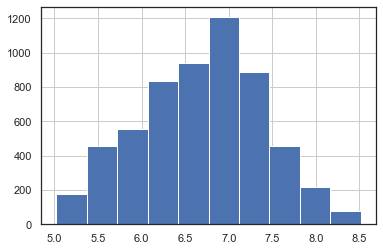

In [319]:
geo_df3['ln_price'].hist()

In [271]:
geo_df3.drop(ind_price_out, axis = 0, inplace  =True)

In [195]:
geo_df2.bathrooms.value_counts()


1.0     3883
2.0     1149
1.5      440
2.5      198
3.0      115
3.5       37
4.0       17
0.5        9
4.5        5
5.5        3
5.0        2
7.5        2
6.0        2
0.0        2
8.5        1
11.0       1
Name: bathrooms, dtype: int64

In [193]:
geo_df2.bedrooms.value_counts()
    

1.0     3382
2.0     1803
3.0      451
0.0      151
4.0       54
5.0       10
6.0        9
11.0       2
7.0        2
10.0       1
24.0       1
Name: bedrooms, dtype: int64

In [252]:
dummies = ['host_is_superhost', 'host_has_profile_pic',
             'insta_book', 'req_guest_phone_ver',
           'has_wifi', 'allows_pets', 'has_gym', 'has_breakfast',
            'has_parking', 'pool', 'hot_tub', 'elevator', 'smoking_allowed', 'host_id_ver'
          ]

In [179]:
for dum in dummies:
    x_clean[dum] = x_clean[dum].astype(int)

<ipython-input-179-f8fadafe18db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_clean[dum] = x_clean[dum].astype(int)


In [180]:

def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

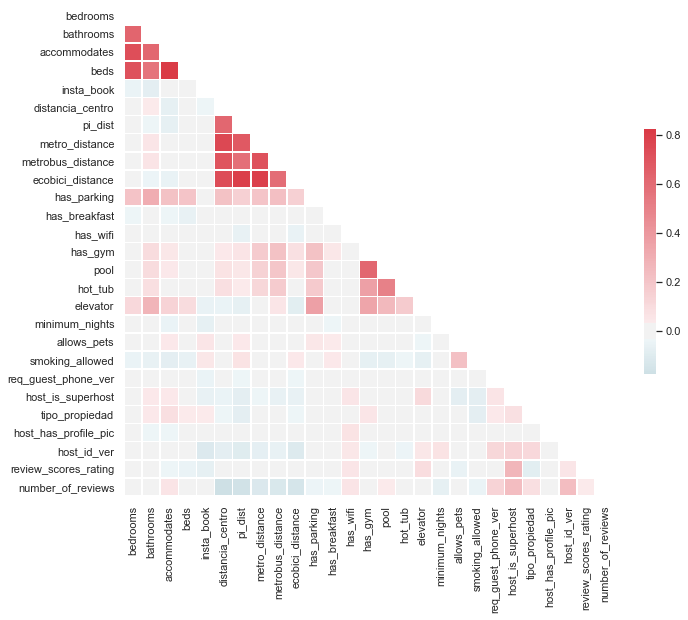

In [181]:
multi_collinearity_heatmap(x_clean)

In [447]:
geo_df3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5810 entries, 0 to 5865
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   level_0                        5810 non-null   int32         
 1   index                          5810 non-null   int32         
 2   id                             5810 non-null   int32         
 3   host_response_rate             5810 non-null   int32         
 4   host_is_superhost              5810 non-null   int32         
 5   host_total_listings_count      5810 non-null   float64       
 6   host_has_profile_pic           5810 non-null   int32         
 7   host_id_ver                    5810 non-null   int32         
 8   latitude                       5810 non-null   float64       
 9   longitude                      5810 non-null   float64       
 10  accommodates                   5810 non-null   int32         
 11  bathrooms

In [244]:
geo_df3 = geo_df2.copy()

In [253]:
for dum in dummies:
    geo_df3[dum] = geo_df3[dum].astype(int)

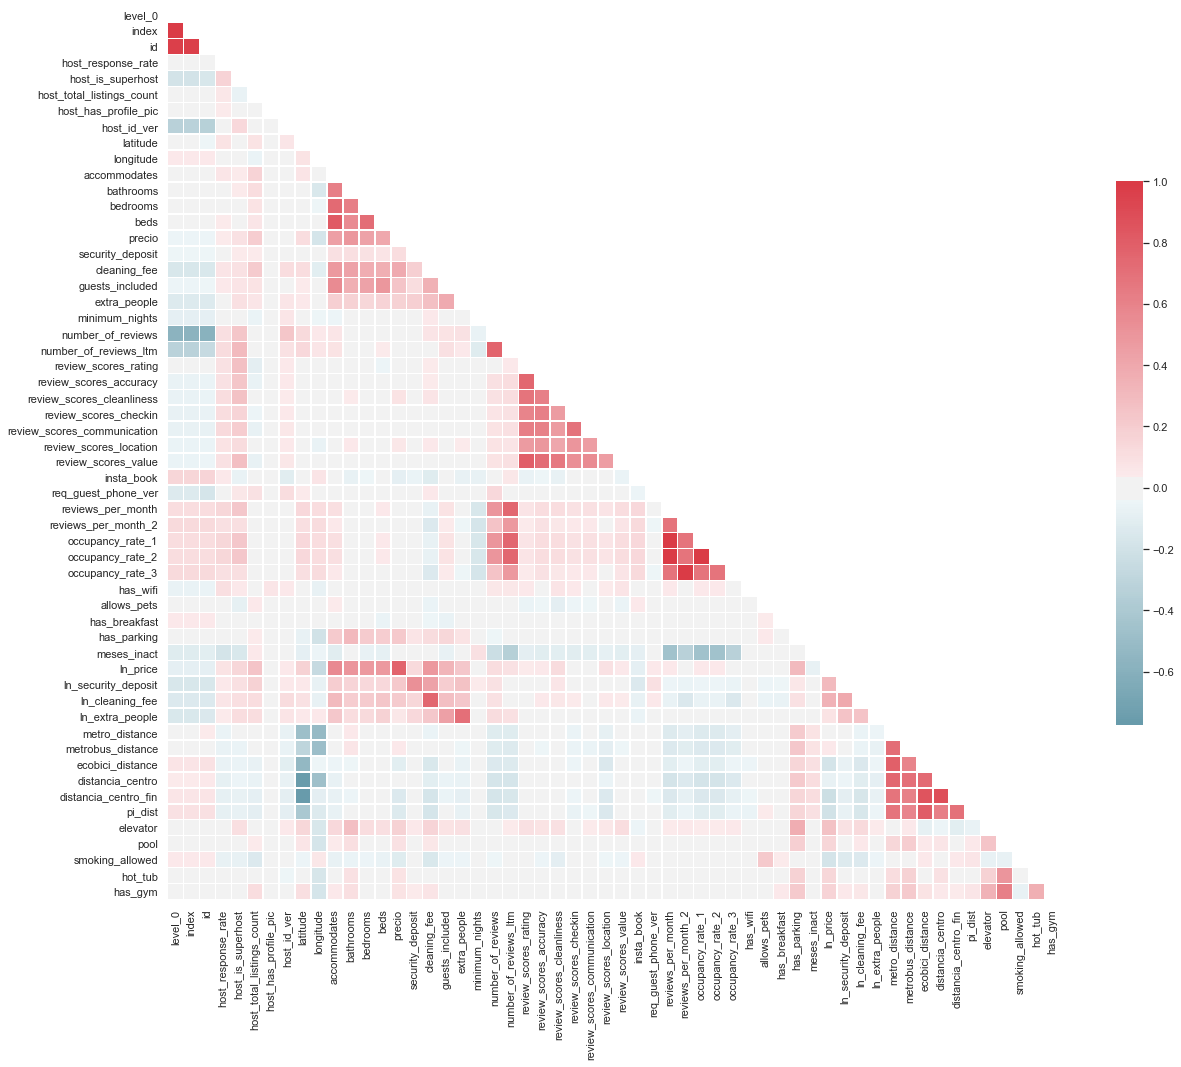

In [254]:
multi_collinearity_heatmap(geo_df3, figsize=(20,20))

In [226]:
geo_df3[geo_df3['precio'] <= 5000].id

0          58955
1          67703
2          70644
3         107078
4         171109
          ...   
4992    33331130
4993    33334187
4994    33337872
4995    33341187
4996    33342032
Name: id, Length: 4950, dtype: int32

In [224]:
geo_df3.loc[5865].precio

5869.0

In [231]:
geo_df2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5866 entries, 0 to 5865
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   level_0                        5866 non-null   int32         
 1   index                          5866 non-null   int32         
 2   id                             5866 non-null   int32         
 3   host_response_rate             5866 non-null   int32         
 4   host_is_superhost              5866 non-null   int32         
 5   host_total_listings_count      5866 non-null   float64       
 6   host_has_profile_pic           5866 non-null   int32         
 7   host_id_ver                    5866 non-null   int32         
 8   latitude                       5866 non-null   float64       
 9   longitude                      5866 non-null   float64       
 10  accommodates                   5866 non-null   int32         
 11  bathrooms

In [211]:
geo_df3['ln_price'].isna().sum()

0

In [212]:
geo_df3['precio'].value_counts()

5869.0    1
1947.0    1
1949.0    1
1950.0    1
1951.0    1
         ..
3918.0    1
3919.0    1
3920.0    1
3921.0    1
0.0       1
Name: precio, Length: 5810, dtype: int64

<AxesSubplot:>

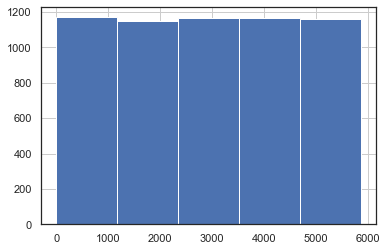

In [230]:
geo_df3.precio.hist(bins = 5)

<AxesSubplot:>

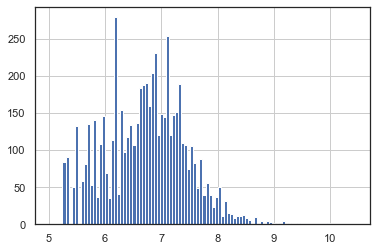

In [213]:
geo_df3.ln_price.hist(bins = 100)

In [251]:
x_clean

bedrooms  bathrooms  accommodates  beds insta_book  distancia_centro  \
0          1.0        1.5             2   1.0          0          2.809889   
1          2.0        1.0             4   3.0          0          4.437041   
2          1.0        1.0             2   1.0          1          9.042816   
3          1.0        1.5             2   1.0          1          6.428138   
4          1.0        1.0             2   1.0          0          6.129953   
...        ...        ...           ...   ...        ...               ...   
5861       1.0        1.0             2   1.0          0          4.318678   
5862       2.0        1.0             3   2.0          1          5.298331   
5863       2.0        1.0             6   3.0          0          1.767796   
5864       1.0        1.0             1   1.0          1          7.715418   
5865       2.0        2.0             5   2.0          1          3.306208   

       pi_dist  metro_distance  metrobus_distance  ecobici_distance  \
0     0.679148        0.452856           0.462915          0.075172   
1     0.717691        0.906474           0.428242          0.079134   
2     0.125432        1.110375           2.304210          0.406757   
3     0.317670        0.441247           2.669878          0.146662   
4     2.075343        1.109405           0.439653          0.110413   
...        ...             ...                ...               ...   
5861  0.765044        0.719949           0.465916          0.124294   
5862  1.851774        1.007846           2.752041          0.167532   
5863  0.283785        0.247251           0.157669          0.066554   
5864  1.311269        1.653224           4.004464          0.167812   
5865  0.441634        0.203105           0.147643          0.079864   

     has_parking has_breakfast has_wifi has_gym pool hot_tub elevator  \
0              1             0        1       0    0       0        1   
1              0             0        1       0    0       0        0   
2              1             0        1       0    0       0        0   
3              1             0        1       0    0       0        1   
4              0             0        1       0    0       0        1   
...          ...           ...      ...     ...  ...     ...      ...   
5861           1             0        1       0    0       0        1   
5862           0             0        1       0    0       0        1   
5863           1             0        1       0    0       0        1   
5864           1             0        1       1    1       1        1   
5865           1             0        1       1    0       0        1   

      minimum_nights allows_pets smoking_allowed req_guest_phone_ver  \
0                  3           0               0                   0   
1                  2           0               0                   0   
2                  3           0               0                   0   
3                  4           1               0                   0   
4                  4           0               0                   0   
...              ...         ...             ...                 ...   
5861               1           0               1                   0   
5862               2           0               0                   0   
5863               1           0               0                   0   
5864               1           0               1                   0   
5865               1           0               0                   0   

     host_is_superhost tipo_propiedad host_has_profile_pic host_id_ver  \
0                    0        Privado                    1           1   
1                    1      Comercial                    1           1   
2                    1      Comercial                    1           1   
3                    0      Comercial                    1           1   
4                    1      Comercial                    1           0   
...                ...        